In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [2]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '050325'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(pheatmap)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_050225.xlsx")) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [3]:
head(full_df)
dim(full_df)

,SampleID,HAWC_ID,Study,Metric,Sample,Class,DTXSID,Name,Value
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Li,Li,1.794436
2,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,K,K,60000.000000
3,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Ca,Ca,2800.000000
4,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Cd,Cd,25.000000
5,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Fe,Fe,1400.000000
6,993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Mn,Mn,280.000000


[1] 727   9

This analysis will use PCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar using PCA.

In [4]:
# will run PCA on each class, so the df will be split
split_df = full_df %>%
    # removing outliers
    group_by(Metric) %>%
    group_split

vol_df = split_df[[1]]
weight_df = split_df[[2]]

head(vol_df)

SampleID,HAWC_ID,Study,Metric,Sample,Class,DTXSID,Name,Value
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Li,Li,1.794436
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,K,K,60000.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Ca,Ca,2800.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Cd,Cd,25.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Fe,Fe,1400.000000
993956_WS,993956,Ihantola et al. 2022,Volume,WS,Metal,Mn,Mn,280.000000


In [5]:
`%notin%` <- Negate(`%in%`) 
wider_vol_df = vol_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_weight_df = weight_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

head(wider_vol_df)

,HAWC_ID,Study,Metric,Sample,Li,K,Ca,Cd,Fe,Mn,⋯,DTXSID0023909,DTXSID8024153,DTXSID4047753,DTXSID3023764,DTXSID3024289,DTXSID3023845,DTXSID8024105,DTXSID7058701,DTXSID3039242,DTXSID7021360
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
993956_WS,993956,Ihantola et al. 2022,Volume,WS,1.794436,60000.00,2800.00,25.0000,1400.000,280.000,⋯,4386.193,606.0000,162.0000,562.0000,2070.000,78000.42,51887.57,80.00000,382000,38800
266980_WS,266980,Stockfelt et al. 2012,Volume,WS,1.773940,9250.00,53617.09,268.4627,6525.903,3770.318,⋯,13.750,31.5000,3.3000,441.4371,1448.445,58500.54,19847.08,33.01373,27000,22500
1263480_WS,1263480,Burnet et al. 1990,Volume,WS,2.918942,1593166.67,374250.00,1833.3333,25791.667,11708.333,⋯,79458.333,12977.8552,390.9083,504500.0000,1269583.333,10961166.67,1219541.67,197.31947,111230625,39687250
1263484_WS,1263484,Leese et al. 1989,Volume,WS,2.918942,1730140.00,61230.00,3480.0000,38670.000,15885.000,⋯,20000.000,20000.0000,390.9083,229846.6845,555000.000,1950000.00,765000.00,197.31947,35722210,18670964
885041_WS,885041,Ihantola et al. 2020,Volume,WS,4.375000,99550.00,3710.00,152.0000,1088.500,133.000,⋯,12541.060,2250.0000,1320.0000,10550.0000,25500.000,574946.98,87032.81,435.00000,14692921,6377825
1070627_WF,1070627,Siregar et al. 2022,Volume,WF,0.300000,786.75,982.65,5.4500,771.000,35.550,⋯,9557.920,576.4716,529.9661,28471.2445,20645.472,168112.08,64082.91,195.59400,9150490,5187882


# Principal Component Analysis (PCA)

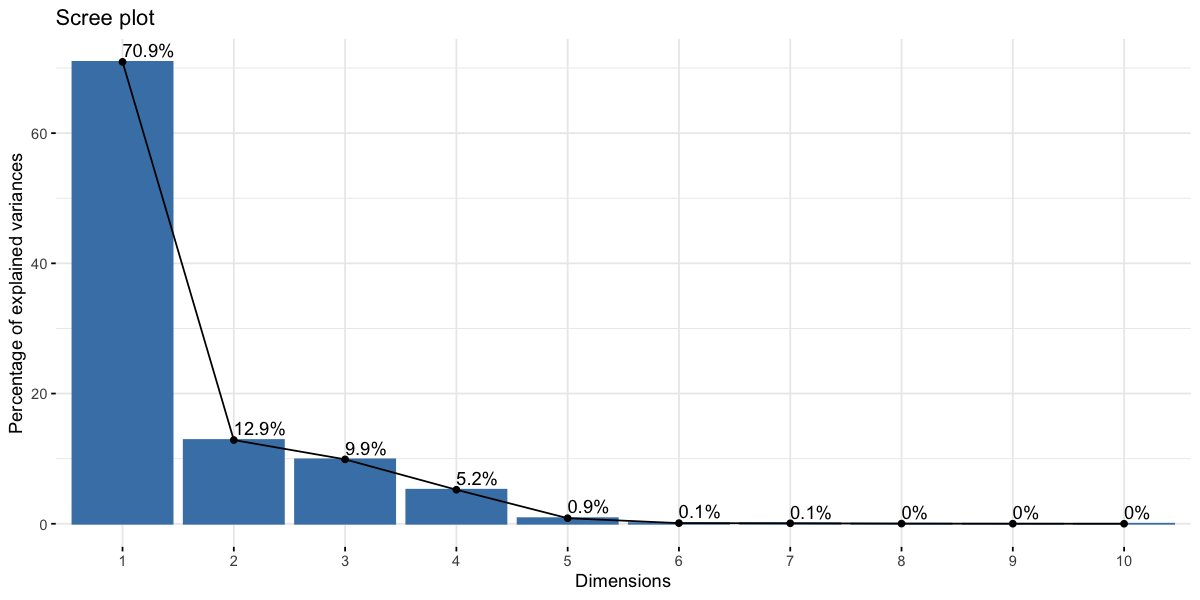

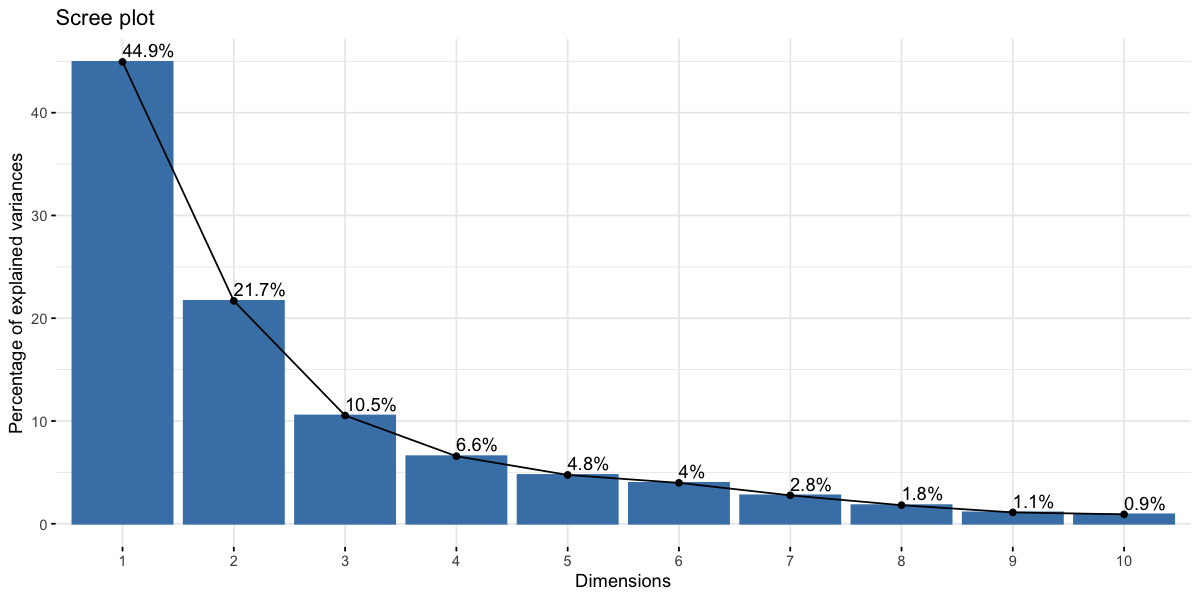

In [6]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(vol_pca, addlabels = TRUE)
fviz_eig(weight_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [7]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
vol_outliers = outlier_detection(vol_pca)
weight_outliers = outlier_detection(weight_pca)

In [8]:
# getting length
length(vol_outliers)
length(weight_outliers)

[1] 0

[1] 0

There were no outliers.

In [9]:
# creating 1 df with eigenvectors and metadata
vol_pca_df = data.frame(vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
weight_pca_df = data.frame(weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID") 

more_data_df = rbind(wider_vol_df[,1:4] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_weight_df[,1:4] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(vol_pca_df, weight_pca_df), 
                                             more_data_df) %>%
    # cleaning variable names here
    mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire",
                                      ifelse(Sample == "Diesel", "Diesel Exhaust", Sample))))

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,HAWC_ID,Study,Metric,Sample
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,993956_WS,-2.720965,-0.1757834,993956,Ihantola et al. 2022,Volume,Woodsmoke
2,266980_WS,-2.460841,0.3545670,266980,Stockfelt et al. 2012,Volume,Woodsmoke
3,1263480_WS,8.363102,-2.9330343,1263480,Burnet et al. 1990,Volume,Woodsmoke
4,1263484_WS,3.942663,3.1904791,1263484,Leese et al. 1989,Volume,Woodsmoke
5,885041_WS,-1.951610,-1.4802008,885041,Ihantola et al. 2020,Volume,Woodsmoke
6,1070627_WF,-2.364628,-0.7508605,1070627,Siregar et al. 2022,Volume,Wildfire


In [10]:
# getting the default ggplot colors
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

# calling fn 
cols = gg_color_hue(4)

# getting color palette
palette_colors = brewer.pal(7, "OrRd")

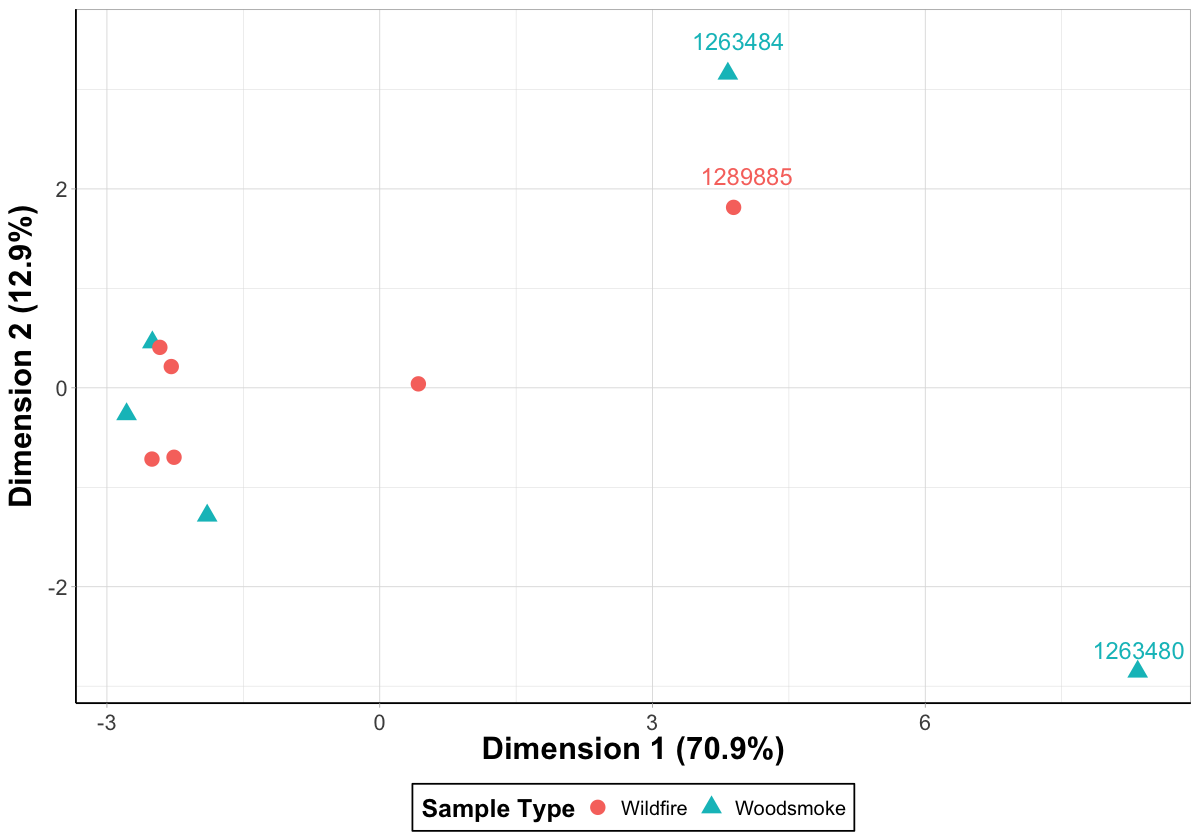

In [69]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol_pca_figure = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume'), aes(x = PC1, y = PC2, color = Sample, shape = Sample),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', PC1 > 3), 
                  aes(x = PC1, y = PC2, color = Sample, label = HAWC_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (70.9%)', y = 'Dimension 2 (12.9%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") #+ #changing legend title

  #scale_color_manual(values = c(cols[2:3], palette_colors[5], cols[4]))

vol_pca_figure

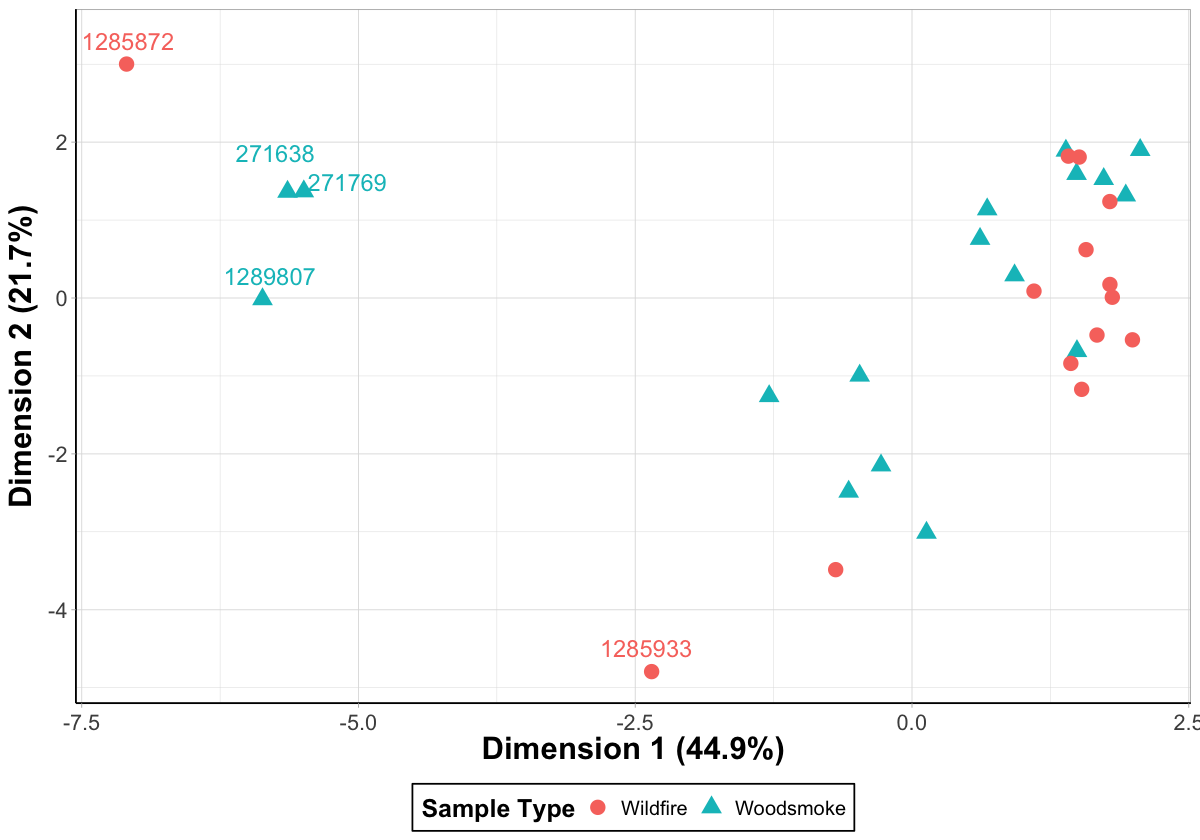

In [70]:
weight_pca_figure = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight'), 
       aes(x = PC1, y = PC2, color = Sample, shape = Sample)) + 
  geom_point(size = 4, position = position_jitter(w = 0.08)) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', PC1 < -2.4), 
                  aes(x = PC1, y = PC2, color = Sample, label = HAWC_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (44.9%)', y = 'Dimension 2 (21.7%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") #+ #changing legend title

  #scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4]))

weight_pca_figure

# Heatmaps

In [64]:
wider_vol_df

,HAWC_ID,Study,Metric,Sample,Li,K,Ca,Cd,Fe,Mn,⋯,Benzo(k)fluoranthene,"Indeno(1,2,3-cd)pyrene",Perylene,Benzo(e)pyrene,Pyrene,Acenaphthylene,Fluorene,Retene,Benzene,Toluene
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
993956_WS,993956,Ihantola et al. 2022,Volume,WS,1.794436,60000.00,2800.00,25.0000,1400.000,280.000,⋯,4386.193,606.0000,162.0000,562.0000,2070.000,7.800042e+04,5.188757e+04,80.00000,382000,38800
266980_WS,266980,Stockfelt et al. 2012,Volume,WS,1.773940,9250.00,53617.09,268.4627,6525.903,3770.318,⋯,13.750,31.5000,3.3000,441.4371,1448.445,5.850054e+04,1.984708e+04,33.01373,27000,22500
1263480_WS,1263480,Burnet et al. 1990,Volume,WS,2.918942,1593166.67,374250.00,1833.3333,25791.667,11708.333,⋯,79458.333,12977.8552,390.9083,504500.0000,1269583.333,1.096117e+07,1.219542e+06,197.31947,111230625,39687250
1263484_WS,1263484,Leese et al. 1989,Volume,WS,2.918942,1730140.00,61230.00,3480.0000,38670.000,15885.000,⋯,20000.000,20000.0000,390.9083,229846.6845,555000.000,1.950000e+06,7.650000e+05,197.31947,35722210,18670964
885041_WS,885041,Ihantola et al. 2020,Volume,WS,4.375000,99550.00,3710.00,152.0000,1088.500,133.000,⋯,12541.060,2250.0000,1320.0000,10550.0000,25500.000,5.749470e+05,8.703281e+04,435.00000,14692921,6377825
1070627_WF,1070627,Siregar et al. 2022,Volume,WF,0.300000,786.75,982.65,5.4500,771.000,35.550,⋯,9557.920,576.4716,529.9661,28471.2445,20645.472,1.681121e+05,6.408291e+04,195.59400,9150490,5187882
1289884_WF,1289884,Samsonova et al. 2012,Volume,WF,2.918942,147241.38,210071.43,850.4578,16122.308,13610.345,⋯,18928.694,5487.6117,408.8692,79835.7460,176548.286,1.340170e+06,3.969093e+05,204.59653,23504011,9153216
1289885_WF,1289885,Samsonov et al. 2005,Volume,WF,2.918942,297833.33,325933.33,1952.4827,52216.667,27550.000,⋯,32066.293,12583.6202,390.9083,224824.1636,580302.871,3.549845e+06,7.619991e+05,197.31947,40159705,18670800
1289909_WF,1289909,Trieu et al. 2024,Volume,WF,1.878469,38550.44,670.00,204.8322,300.000,4.900,⋯,9556.522,0.0320,504.4529,28575.4696,0.040,3.900000e-03,4.000000e-02,208.79080,9122090,5185600


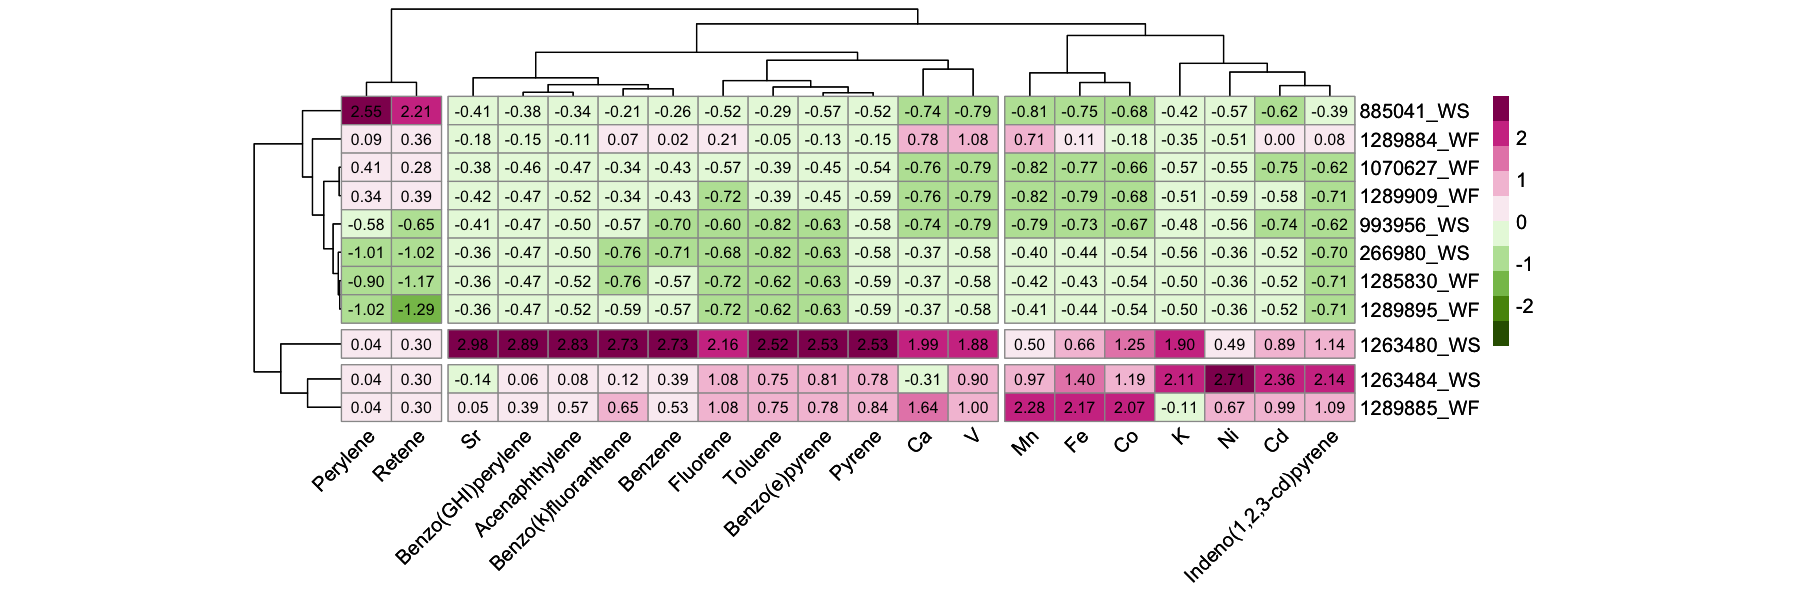

In [66]:
options(repr.plot.width=15, repr.plot.height=5) #changing size
fall_colors = rev(palette(hcl.colors(10, "PiYG")))

wider_vol_df = vol_df %>%
    select(-c("DTXSID", "Class")) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

vol_map = pheatmap(wider_vol_df[,6:ncol(wider_vol_df)], cluster_rows = TRUE, cluster_cols = TRUE, 
         #annotation_row = wider_vol_df$Sample,
         angle_col = 45, fontsize = 12, scale = 'column',
         cellheight = 17, cellwidth = 30,
         color = fall_colors,
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3, cutree_col = 3) # adds a break bewtween the largest clusters

vol_map

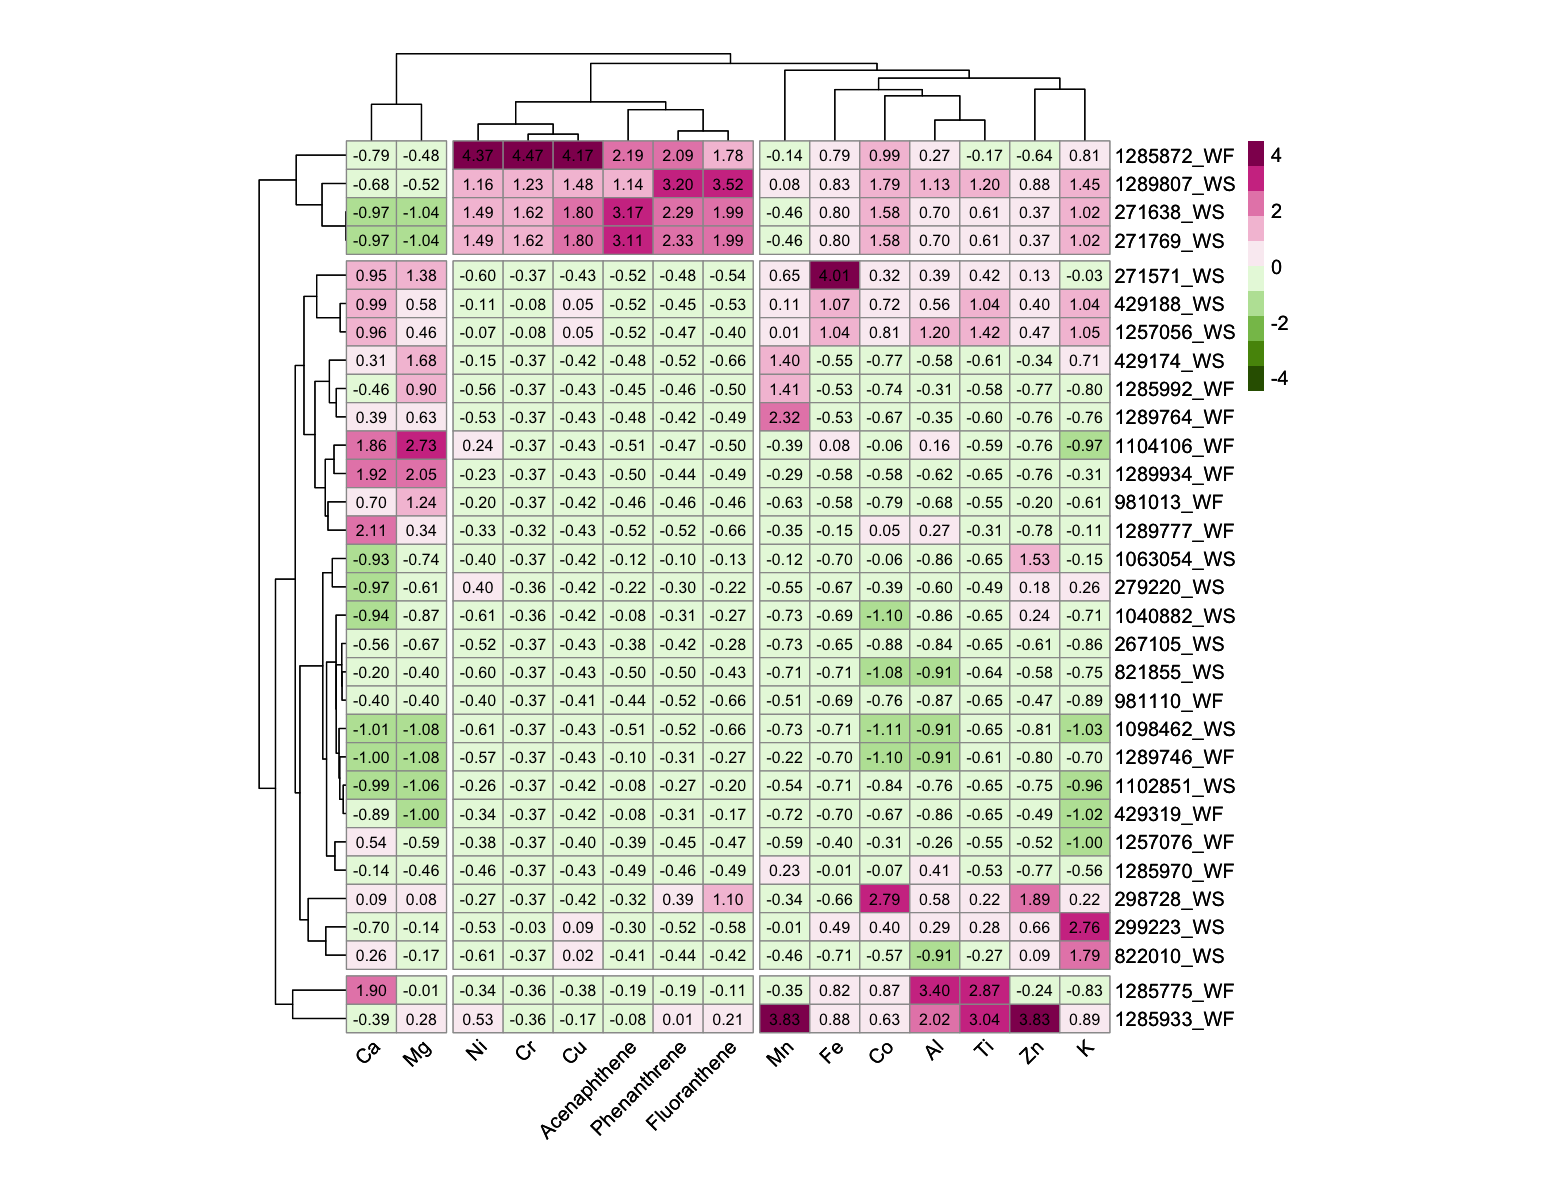

In [62]:
options(repr.plot.width=13, repr.plot.height=10) #changing size
wider_weight_df = weight_df %>%
    select(-c("DTXSID", "Class")) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

weight_map = pheatmap(wider_weight_df[,6:ncol(wider_weight_df)], cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12, scale = 'column',
         cellheight = 17, cellwidth = 30,
         color = fall_colors,
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3, cutree_col = 3) # adds a break bewtween the largest clusters

weight_map

# PCA & Heatmaps

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

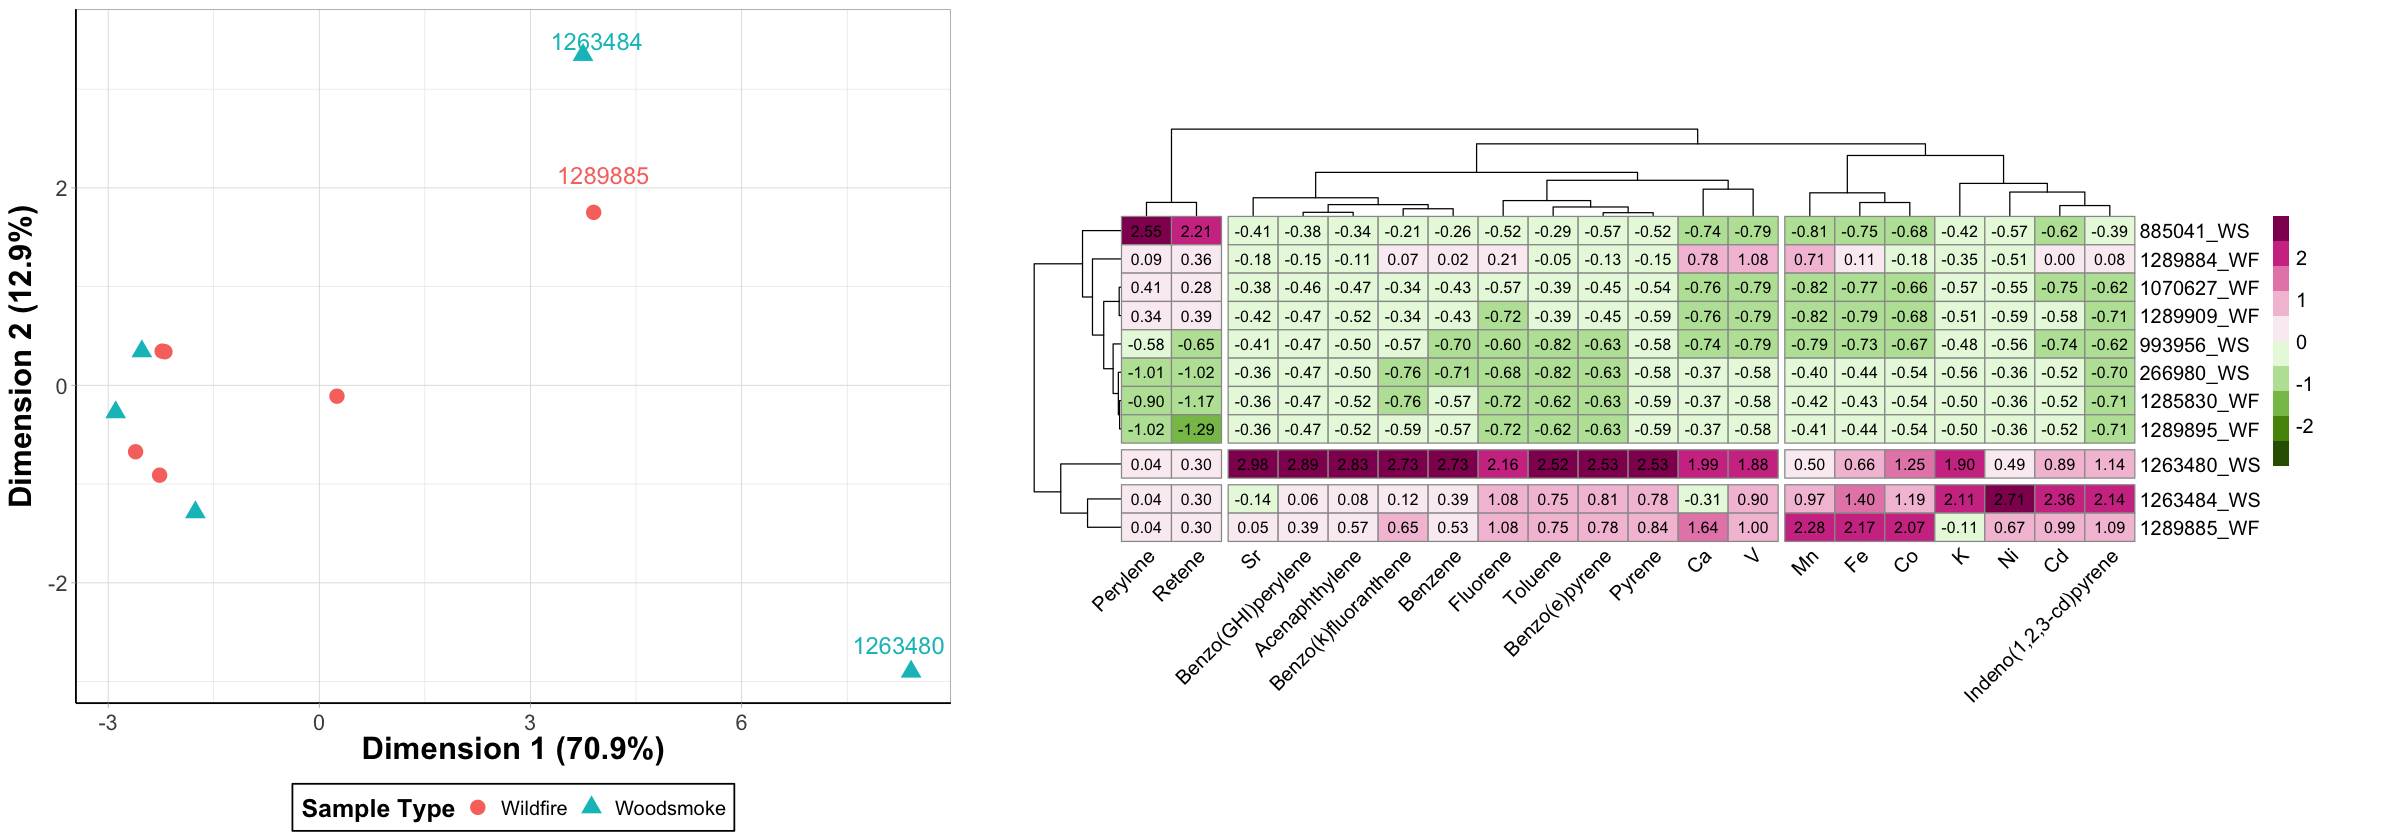

In [63]:
options(repr.plot.width=20, repr.plot.height=7) #changing size
# creating 1 figure
vol_fig = grid.arrange(vol_pca_figure, vol_map[[4]],  widths = c(0.4, 0.6), ncol = 2)
vol_fig

TableGrob (3 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-3,2-2) arrange gtable[layout]
2 2 (1-1,1-1) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (3-3,1-1) arrange gtable[layout]

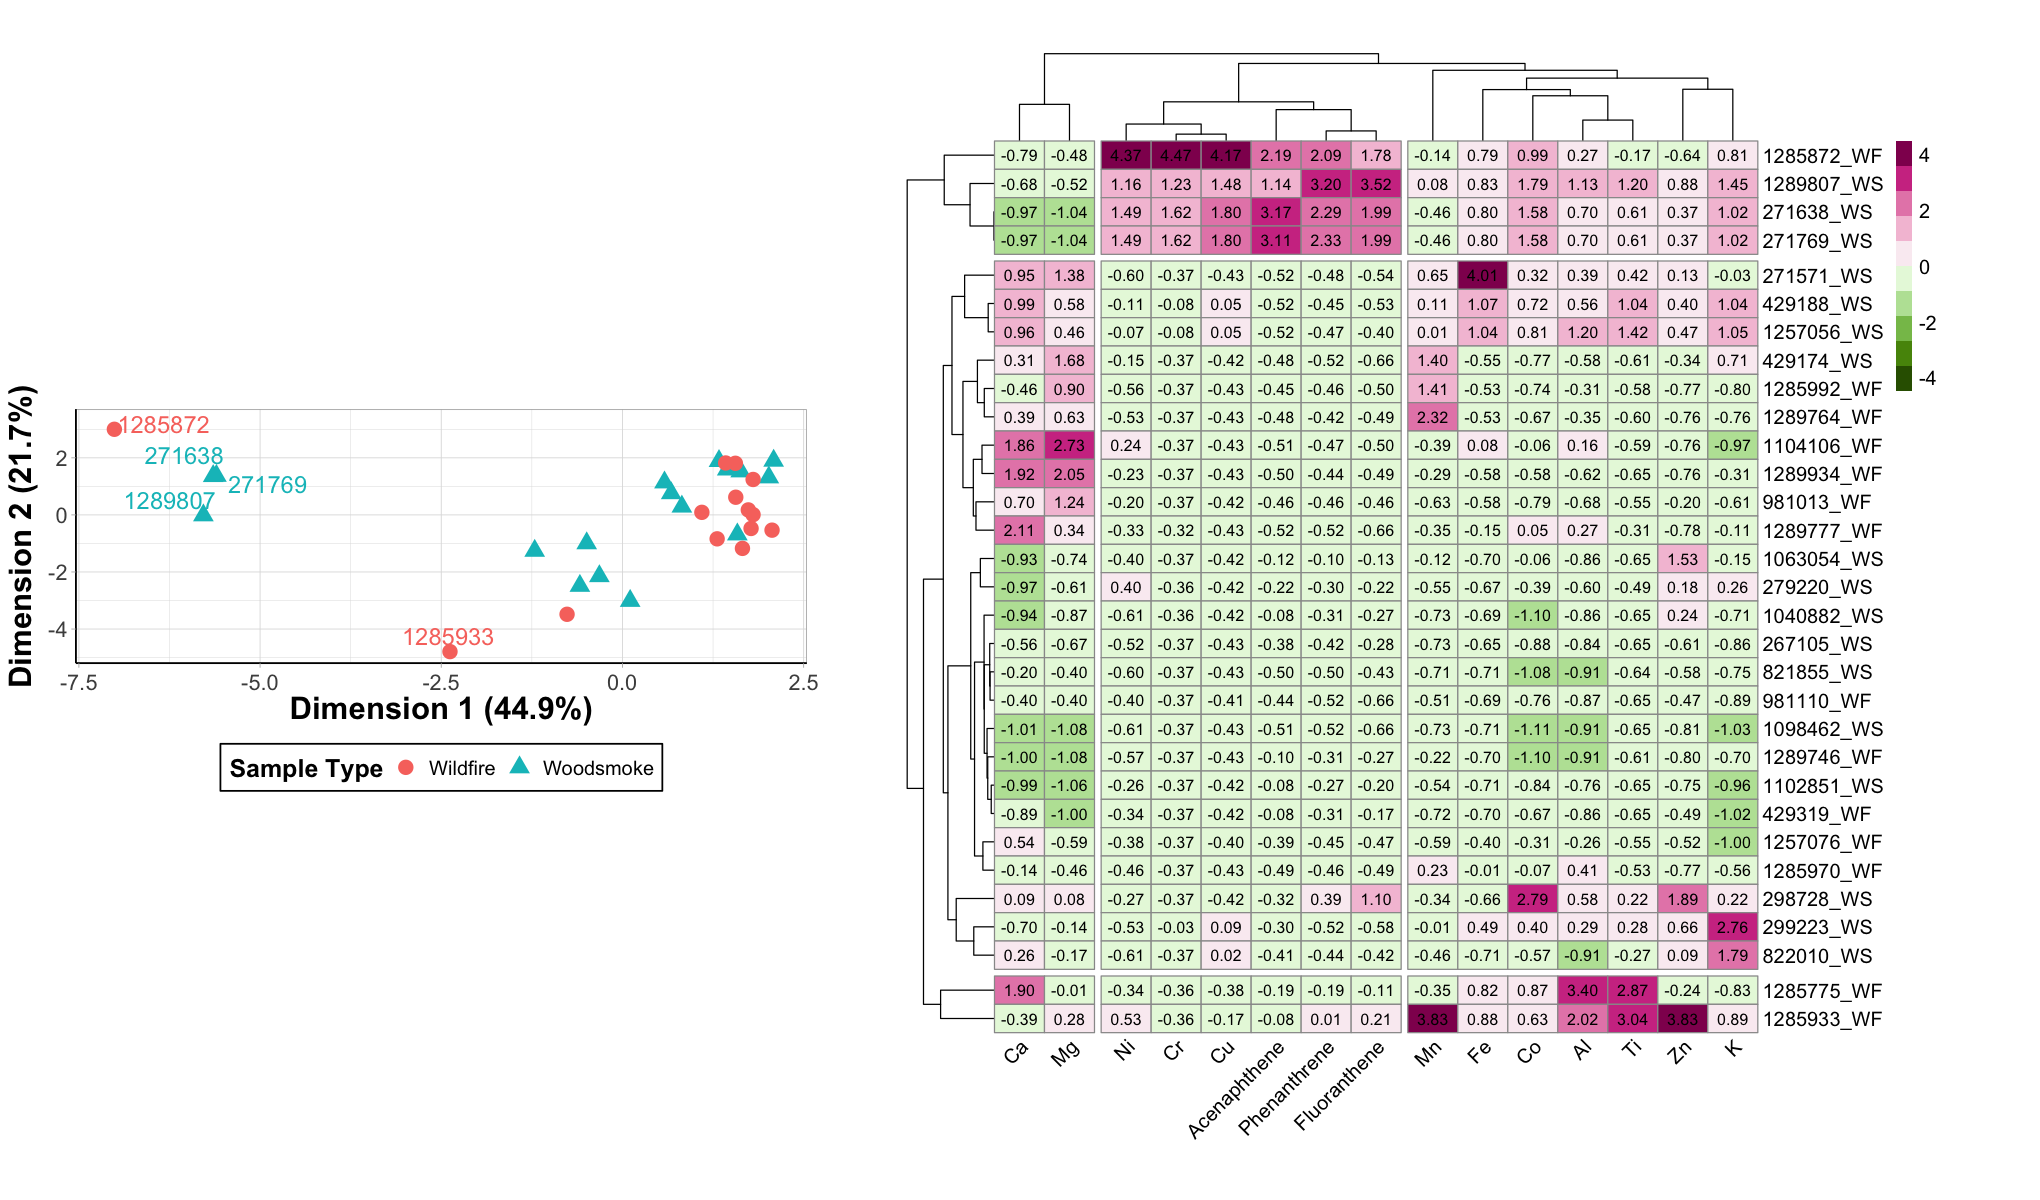

In [84]:
options(repr.plot.width=3, repr.plot.height=3) #changing size
blank_plot = ggplot() + 
  geom_blank(aes(1,1)) + 
   theme(
    plot.background = element_blank(), 
   panel.grid.major = element_blank(),
   panel.grid.minor = element_blank(), 
   panel.border = element_blank(),
   panel.background = element_blank(),
   axis.title.x = element_blank(),
   axis.title.y = element_blank(),
   axis.text.x = element_blank(), 
   axis.text.y = element_blank(),
   axis.ticks = element_blank(),
   axis.line = element_blank()
     )
options(repr.plot.width=17, repr.plot.height=10) #changing size
pah_weight_fig = grid.arrange(weight_map[[4]], blank_plot, weight_pca_figure, blank_plot,  widths = c(0.4, 0.6), 
                              #heights = c(1,2), 
                              ncol = 2, layout_matrix = cbind(c(2,3,4), c(1,1,1)))
pah_weight_fig

## Top Metal or Chemical Contributors to PCA

In [85]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

In [86]:
# extracting chemical/metal contributions
get_contributions = function(pca_object, class){
    # ADD WORDS

    # get pca object that contains contributions
    get_pca = get_pca_var(pca_object)
    contrib_df = data.frame(get_pca$cos2)
    
    contrib_vector = c()
    for (i in 1:length(contrib_df$Dim.1)){
        
    contrib = ((get_pca$cos2[i,1] + get_pca$cos2[i,2]) * 100)/(sum(get_pca$cos2[,1]) + sum(get_pca$cos2[,2]))
    contrib_vector = c(contrib_vector, contrib)
        
    }
    
    contrib_df = data.frame(Variable = rownames(get_pca$cos2), Contribution = contrib_vector) %>%
        arrange(-Contribution) %>%
        # creating a new col to dictate colors
        mutate(Significance = ifelse(Contribution > mean(Contribution), "Yes", "No"))

    return(contrib_df)
}

# calling fn
vol_contrib_df = get_contributions(vol_pca)
weight_contrib_df = get_contributions(weight_pca)

head(vol_contrib_df)

,Variable,Contribution,Significance
,<chr>,<dbl>,<chr>
1,Benzene,5.939976,Yes
2,Benzo(k)fluoranthene,5.931782,Yes
3,Fluorene,5.929514,Yes
4,Pyrene,5.897095,Yes
5,Toluene,5.894570,Yes
6,Benzo(e)pyrene,5.886419,Yes


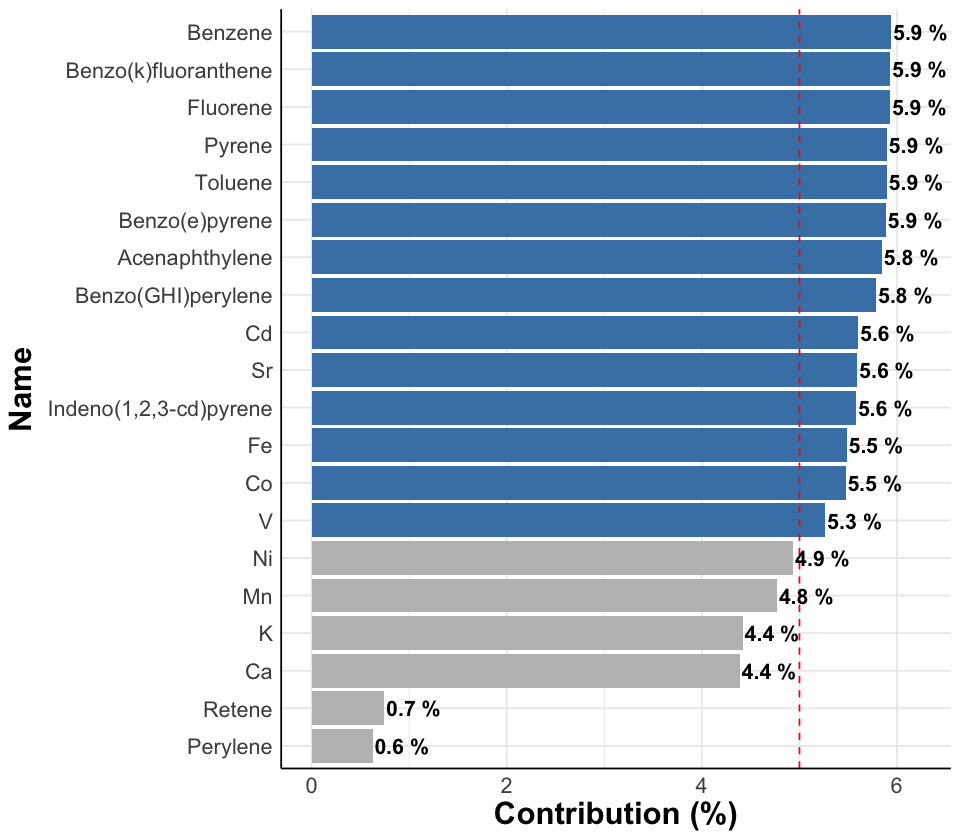

In [88]:
options(repr.plot.width=8, repr.plot.height=7) #changing size
vol_contrib = ggplot(vol_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(vol_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.3, label = paste(round(Contribution, 1), "%")), fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

vol_contrib

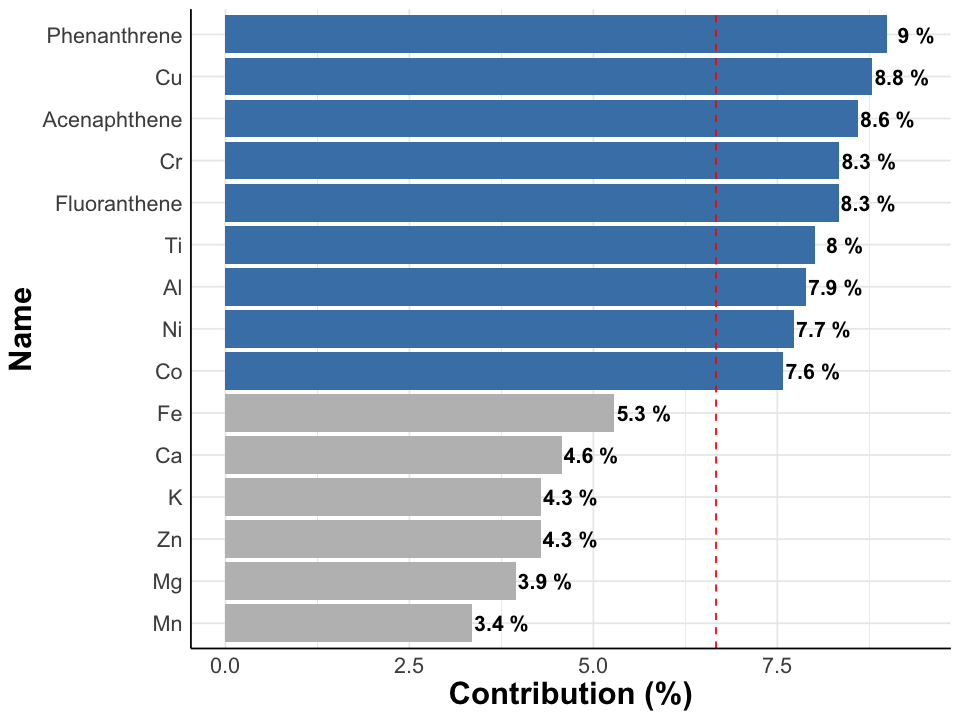

In [89]:
options(repr.plot.width=8, repr.plot.height=6) #changing size
weight_contrib = ggplot(weight_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(weight_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.4, label = paste(round(Contribution, 1), "%")), 
            fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

weight_contrib

In [34]:
# # exporting figures
# ggsave(metal_vol_contrib, 
#        filename = 'metalvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_vol_contrib, 
#        filename = 'pahvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)
# ggsave(voc_vol_contrib, 
#        filename = 'vocvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 10, height = 5)
# ggsave(metal_weight_contrib, 
#        filename = 'metalweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_weight_contrib, 
#        filename = 'pahweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)